# Basic Nighttime Lights Raster Processing


You can get these data packages via the ['sez' tag at the SDRDL Data Repository](https://data.sandiegodata.org/?s=sez)

In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rowgenerators as rg
import fiona
import rasterio
import rasterio.mask
from IPython.display import display 
from rasterio.plot import reshape_as_raster, reshape_as_image, show
from tqdm.notebook import tqdm
from requests import get  # to make GET request
import boto3
import h5py 

%run ./lib.py

%matplotlib inline
sns.set_context('notebook')


In [2]:
# Open the two main data packages
sez_p = mp.open_package('http://library.metatab.org/worldbank.org-sez-1.1.1.csv')

# Displaying the package shows metadata
sez_p

# Special economic zones
`worldbank.org-sez-1.1.1` Last Update: 2021-07-12T20:47:42

_Information on special economic zones have been individually collected and researched in a study focusing on the governance of SEZ. This is just a subset (586) of the extant global SEZs, which have been estimated at 3500-4000._


## Documentation Links

* [Documentation Page](http://library.metatab.org/worldbank.org-sez-1.1.1/index.html) 
* [Dataset webpage](https://datacatalog.worldbank.org/dataset/special-economic-zones-sez) 
* [Dataset viewer web application](http://devseed.com/sez-viewer/#/BGD6) 

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [sez](http://library.metatab.org/worldbank.org-sez-1.1.1/data/sez.csv)**. Special Economic Zones

In [3]:
#sez_p.resource('sez')

In [4]:

# Create Dataframes
sez = sez_p.resource('sez').geoframe()

# Update the SEZ geometries to be a 20KM buffer around the point. We project to 
# EPSG:3395, World Mercator, to be able to make the buffer in meters. 
g =  sez.to_crs(3395).buffer(20_000)

sez['geo_area'] = g.area
sez['geometry'] = g.to_crs(4326)

# The operational date col is a string, so make an int year column. 
sez['year'] = pd.to_numeric(sez.operational_date, errors='coerce')

In [5]:
# Test the file upload

# Download the file
def download(radius):
    """Download patches file, radius in Km"""
    dl_fn = f'patches_{radius}k.h5'
    with open(dl_fn, "wb") as file:
        # get request
        response = get(f'http://public.source.civicknowledge.com.s3.amazonaws.com/sez/sez_circ_patches_{radius}000.h5')
        # write to file
        file.write(response.content)

    return dl_fn
        
# Get a random selection of patches from the file
def get_hdf_keys(f):
    """Return all of the dataset keys in an HDF5 file"""
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys


    
dl_fn = download(10)
dl_fn

'patches_10k.h5'

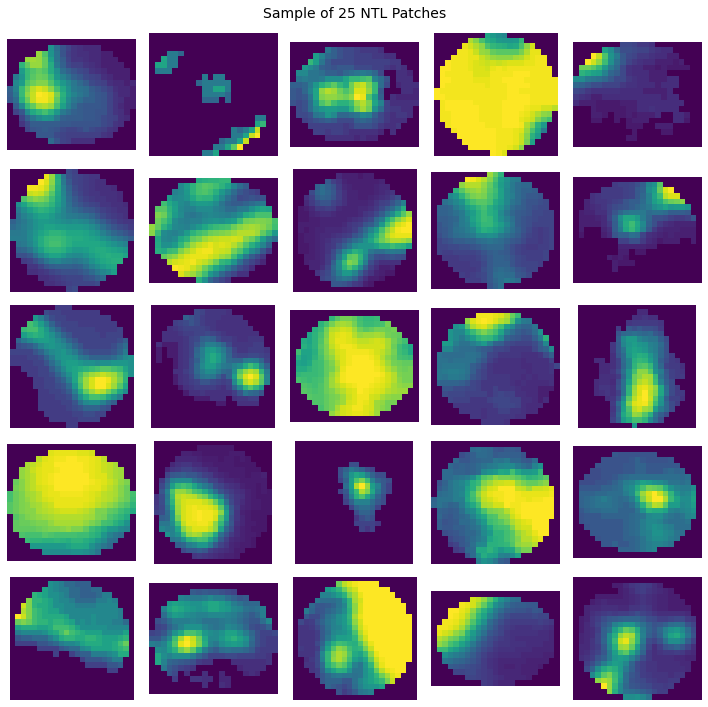

In [6]:
# Plot a random sample
from random import shuffle

with h5py.File(dl_fn, 'r') as f:
    keys = get_hdf_keys(f)

shuffle(keys)

fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = np.ravel(axes)

with h5py.File(dl_fn, 'r') as f:
    for k, a in zip(keys[:len(axes)], axes):
        r = f[k][:]
        a.set_axis_off()
        show(r, ax=a)

fig.suptitle('Sample of 25 NTL Patches', fontsize=14)
plt.tight_layout()

In [7]:
# For each of the patches in the HDF5 file, sum up all of the pixel values. 
with h5py.File(dl_fn, 'r') as f:
    
    keys = get_hdf_keys(f)
    rasters = []
    for k in keys:
        _, sez_id, year = k.split('/')
        rasters.append( (int(year), sez_id, np.nansum(f[k][:])))
        
t = pd.DataFrame(rasters, columns=['year', 'unique_id', 'pixel_sum'])   

t = t.merge(sez.rename(columns={'year':'op_year'}), on='unique_id')
t['mean_light'] = t.pixel_sum / t.geo_area

# Unit Norm
t_ = t.mean_light-t.mean_light.min()
t['mean_light_un'] = (t_/t_.max())

# Get the smallest value for mean_light, to avoid errors with log()
#dt=t['mean_light'].dtype.type
#t['mean_light'] = t['mean_light'].replace(0, np.nextafter(dt(0), dt(1))) # Next after will return the smallest value above zero

t['mean_light'] = t['mean_light'].replace(0, np.nan)

ml = t


/Users/eric/opt/anaconda3/envs/sez/lib/python3.7/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


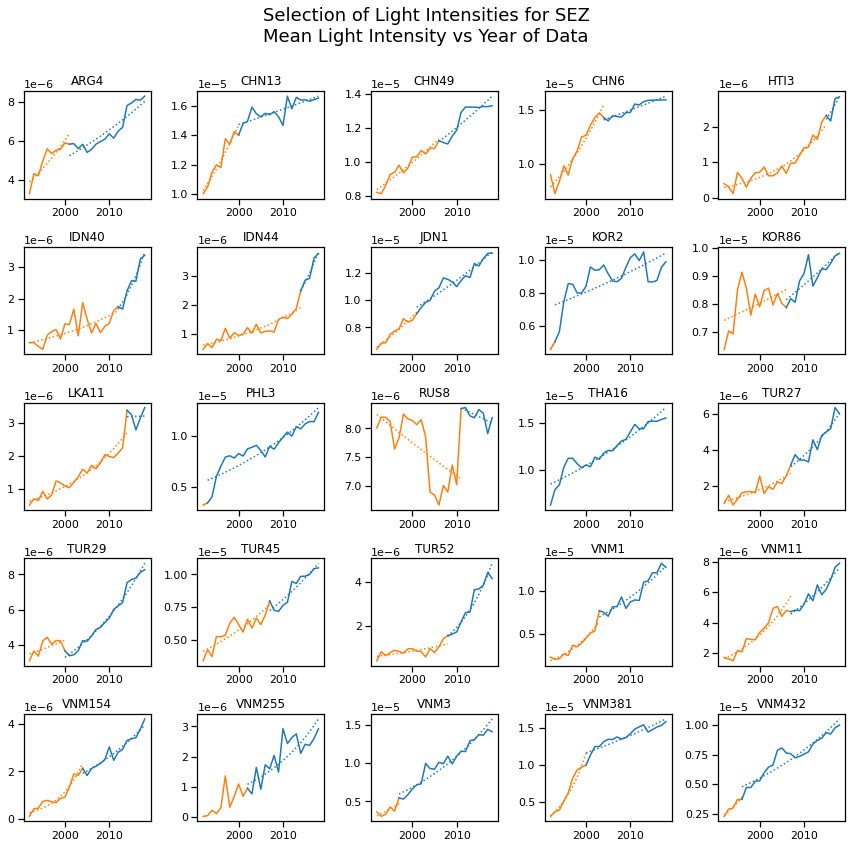

In [8]:
from random import choice

def fit_line(x, y=None):
    r, x0 = exp_line_fit(x, y)
    y_ = x0*(r+1)**x
    return y_
    

def plot_sez_ts(df, title=''):
    
    g = df.groupby('unique_id')

    
    all_keys = list(g.groups.keys()) # Random selection
    shuffle(all_keys)
    
    # Pick a square that is less than the total number of keys, 
    # and also less than 25
    size = int(min(np.floor(np.sqrt(len(all_keys))), 5))
    
    fig, axes = plt.subplots(size,size, figsize=(12,12))
    
    # Preselect the keys so we can sort them for display
    rand_series = []
    ki = iter(all_keys)

    for _ in range(size**2):
        while True: # Skip the ones that are empty
            try:
                uid = next(ki)
                bf, af = split_series(g.get_group(uid))
                if len(bf) > 0 and len(af) > 0:
                    rand_series.append([uid, bf, af])
                    break
            except StopIteration:
                break # Number of non empty is less than size
        

    for ax, (uid, bf, af) in zip(np.ravel(axes),sorted(rand_series, key=lambda e: e[0])) : 

        a1 = ax.plot(bf.year, bf.mean_light, color='tab:orange')
        y_ = fit_line(bf.year, bf.mean_light)
        ax.plot(bf.year, y_, color='tab:orange', linestyle=':')

        ax.plot(af.year, af.mean_light, color='tab:blue')
        y_ = fit_line(af.year, af.mean_light)
        ax.plot(af.year, y_, color='tab:blue', linestyle=':')

        ax.set_title(uid)

    fig.suptitle(f"Selection of Light Intensities for SEZ\nMean Light Intensity vs Year of Data\n{title}", fontsize=18)
    plt.tight_layout()
    
plot_sez_ts(ml)
#plot_sez_ts(ml[ml.country=='Uruguay'], title='Uruguay')

The plot above is a random selection of 25 SEZ, showing the light intensity over time ( solid line ). Where the line is orange is the time before the SEZ become active, and the blue ortion is after. The dotted lines are a line fit to the log of the light intensity, so the slope of the fit is the growth rate of the light intensity, assuming a model of exponential growth. ( Which is why some of the dotted lines are curved. ) 

/Users/eric/proj/data-projects/chartercitiesinstitute.org-sez/notebooks/ericbusboom/lib.py:139: RankWarning: Polyfit may be poorly conditioned
  return pd.Series([exp_line_fit(bf)[0], exp_line_fit(af)[0]])
/Users/eric/proj/data-projects/chartercitiesinstitute.org-sez/notebooks/ericbusboom/lib.py:139: RankWarning: Polyfit may be poorly conditioned
  return pd.Series([exp_line_fit(bf)[0], exp_line_fit(af)[0]])
/Users/eric/proj/data-projects/chartercitiesinstitute.org-sez/notebooks/ericbusboom/lib.py:139: RankWarning: Polyfit may be poorly conditioned
  return pd.Series([exp_line_fit(bf)[0], exp_line_fit(af)[0]])
/Users/eric/proj/data-projects/chartercitiesinstitute.org-sez/notebooks/ericbusboom/lib.py:139: RankWarning: Polyfit may be poorly conditioned
  return pd.Series([exp_line_fit(bf)[0], exp_line_fit(af)[0]])
/Users/eric/proj/data-projects/chartercitiesinstitute.org-sez/notebooks/ericbusboom/lib.py:139: RankWarning: Polyfit may be poorly conditioned
  return pd.Series([exp_line_fit(

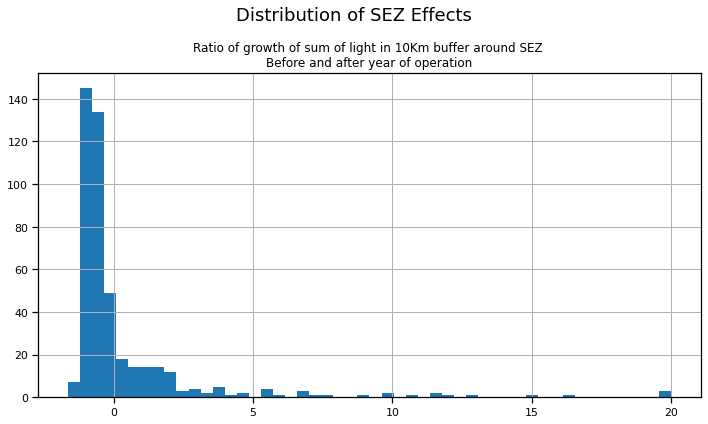

In [9]:
g = ml.groupby('unique_id')

slopes = g.apply(compute_slopes).rename(columns={0:'pre_slope',1:'post_slope'}).reset_index()
slopes['rate_change'] = (slopes.post_slope - slopes.pre_slope)/np.abs(slopes.pre_slope)
slopes['rate_change'] = slopes['rate_change'].clip(-10,20)

# plt.xscale('symlog')
slopes.rate_change.hist(bins = 50, figsize=(10, 6))

plt.suptitle('Distribution of SEZ Effects', fontsize=18)
plt.title('Ratio of growth of sum of light in 10Km buffer around SEZ \nBefore and after year of operation')
plt.tight_layout()

In [10]:
df = sez.merge(slopes[['unique_id','rate_change']])
df.head().T

,0,1,2,3,4
id,0,1,2,3,4
unique_id,URY12,URY2,COL2,GUY3,IND186
check,URY,URY,COL,GUY,IND
latitude,-33.887443,-34.470636,10.960451,6.791794,23.034146
longitude,-58.416899,-57.831424,-74.762902,-58.167016,70.127156
...,...,...,...,...,...
note,NaN,NaN,NaN,The Government has noted that existing industr...,NaN
geometry,POLYGON ((-58.2372359431761 -33.88744299999961...,POLYGON ((-57.65176094317609 -34.4706359999996...,POLYGON ((-74.58323894317608 10.96045099999921...,POLYGON ((-57.98735294317609 6.791793999999445...,"POLYGON ((70.3068190568239 23.03414599999919, ..."
geo_area,1254619396.218367,1254619396.218367,1254619396.218366,1254619396.218365,1254619396.218367
year,1923.0,1923.0,1958.0,1960.0,1965.0


In [11]:
t = df.groupby('country').rate_change.mean().sort_values(ascending=False).dropna()
display(t.head())
display(t.tail())

country
Sudan                11.815522
Russia                5.252995
Republic of Congo     2.777188
Uruguay               2.531912
Pakistan              2.364061
Name: rate_change, dtype: float64

country
Madagascar   -0.807367
Malaysia     -0.819046
Kenya        -0.840423
Fiji         -0.870795
Angola       -0.883641
Name: rate_change, dtype: float64

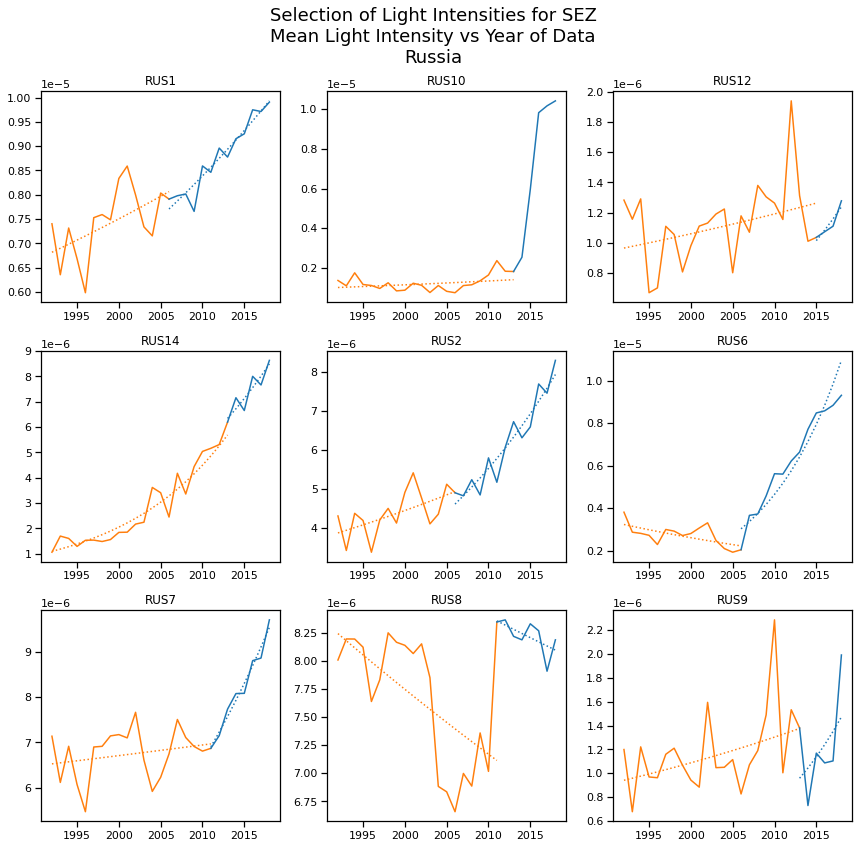

In [12]:
plot_sez_ts(ml[ml.country=='Russia'], title='Russia')

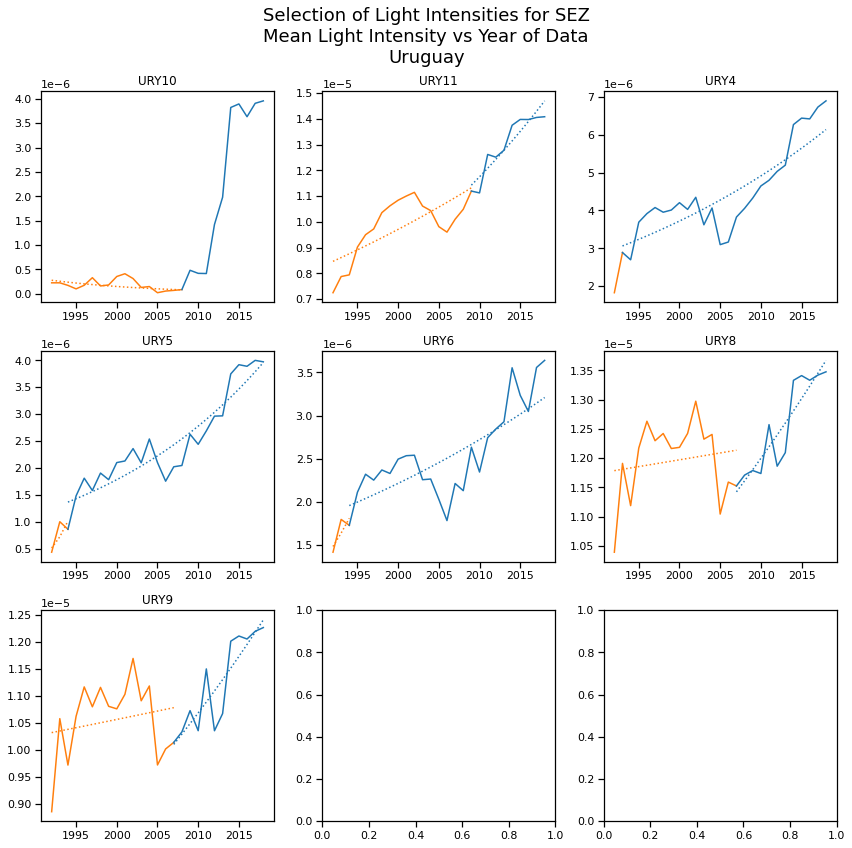

In [13]:
plot_sez_ts(ml[ml.country=='Uruguay'], title='Uruguay')

In [14]:
df.groupby('region').rate_change.mean().sort_values(ascending=False).dropna()


region
ECA     1.512364
SSA     1.095341
LAC     0.900992
SA      0.600628
EAP    -0.173620
MENA   -0.673496
Name: rate_change, dtype: float64

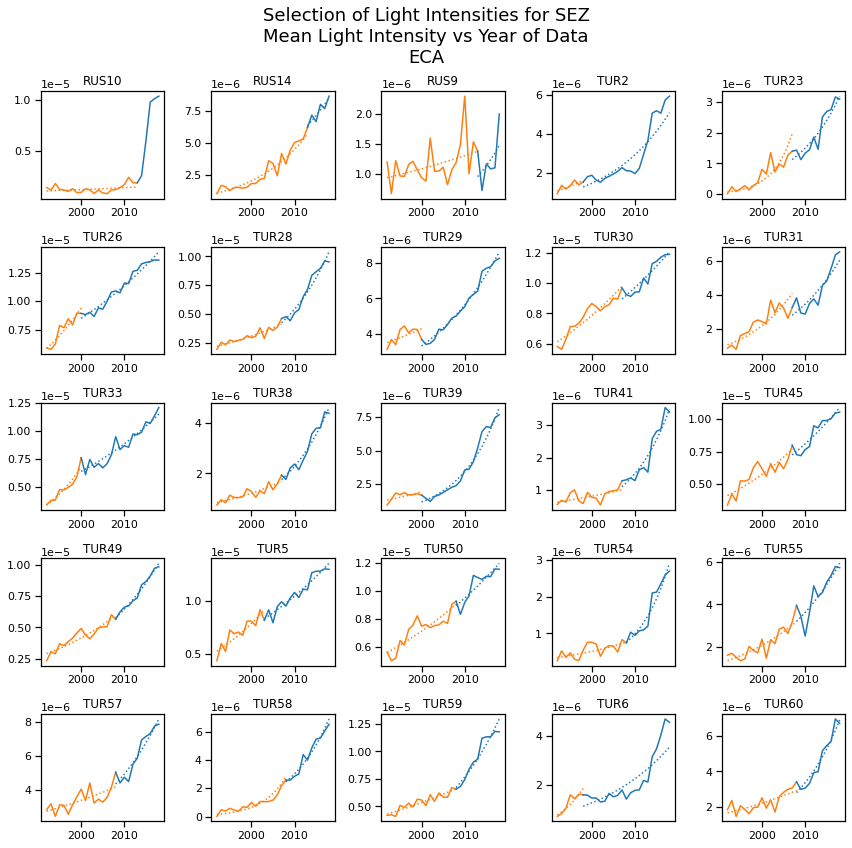

In [15]:
plot_sez_ts(ml[ml.region=='ECA'], title='ECA')

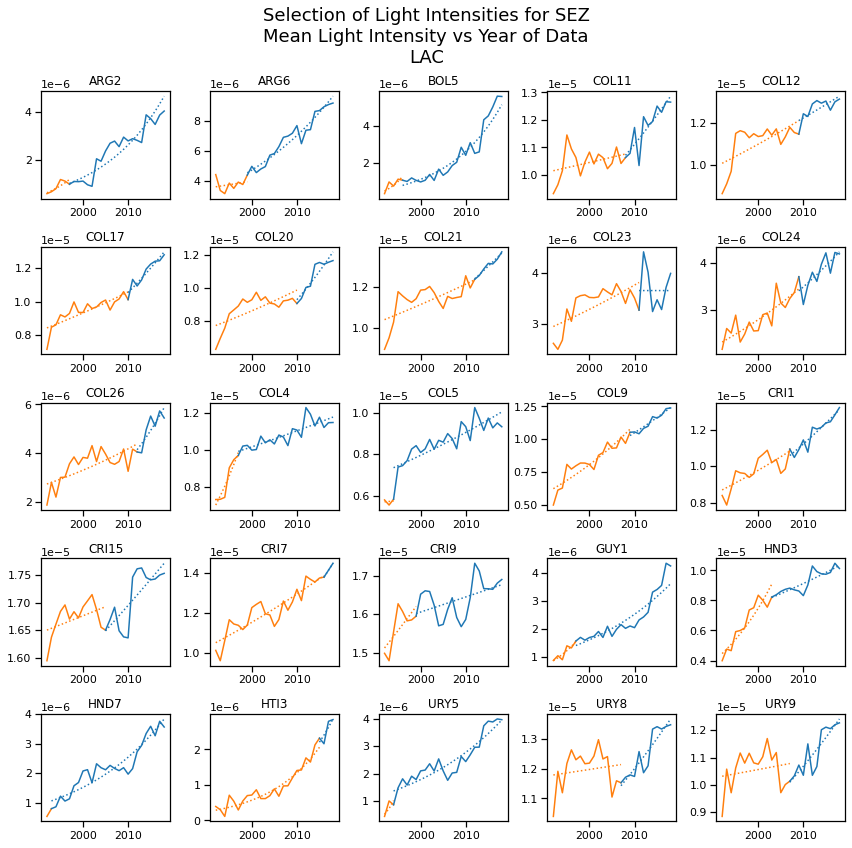

In [16]:
plot_sez_ts(ml[ml.region=='LAC'], title='LAC')

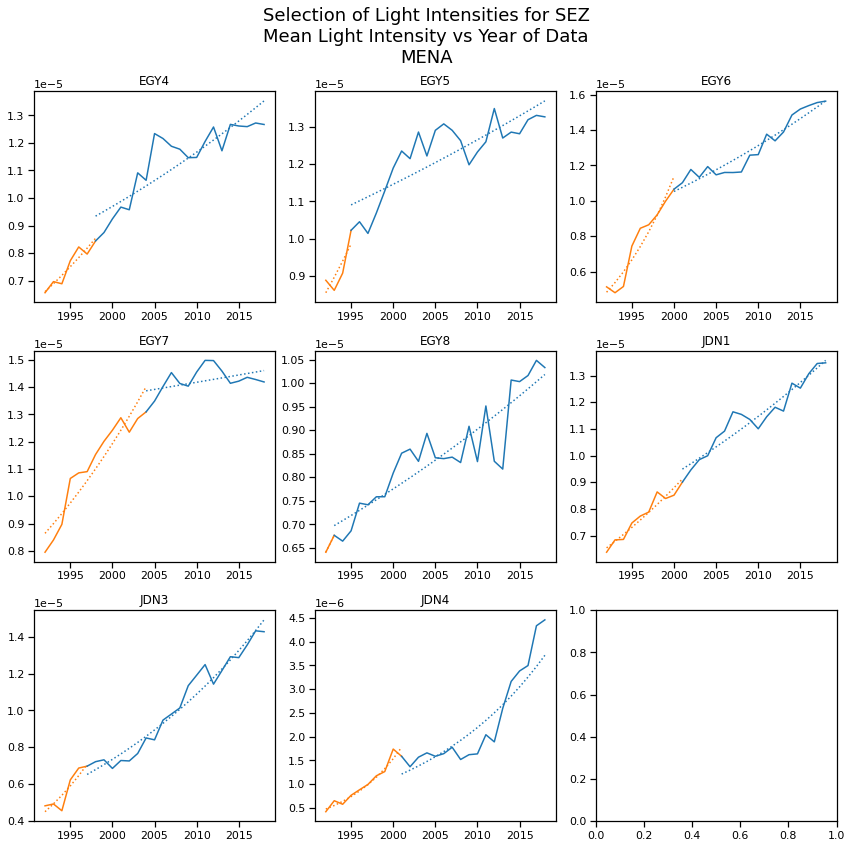

In [17]:
plot_sez_ts(ml[ml.region=='MENA'], title='MENA')

In [18]:
df.groupby('management_type').rate_change.mean().sort_values(ascending=False).dropna()

management_type
State-owned enterprise    0.571838
Private management        0.403394
PPP                       0.385031
Public agency             0.075025
Name: rate_change, dtype: float64

In [19]:
df.groupby('authority_independence').rate_change.mean().sort_values(ascending=False).dropna()

authority_independence
Yes    0.658377
No     0.208383
Name: rate_change, dtype: float64

In [20]:
df.groupby('size_range').rate_change.mean().sort_values(ascending=False).dropna()

size_range
Greater than 5,000 ha    1.183105
300 to 999 ha            0.661794
Less than 30 ha          0.468681
1,000 to 4,999 ha        0.362364
30 to 99 ha              0.280104
100 to 299 ha            0.060591
Name: rate_change, dtype: float64

In [21]:
df.groupby('authority_independence').rate_change.mean().sort_values(ascending=False).dropna()

authority_independence
Yes    0.658377
No     0.208383
Name: rate_change, dtype: float64

In [22]:
df.head().T

,0,1,2,3,4
id,0,1,2,3,4
unique_id,URY12,URY2,COL2,GUY3,IND186
check,URY,URY,COL,GUY,IND
latitude,-33.887443,-34.470636,10.960451,6.791794,23.034146
longitude,-58.416899,-57.831424,-74.762902,-58.167016,70.127156
...,...,...,...,...,...
note,NaN,NaN,NaN,The Government has noted that existing industr...,NaN
geometry,POLYGON ((-58.2372359431761 -33.88744299999961...,POLYGON ((-57.65176094317609 -34.4706359999996...,POLYGON ((-74.58323894317608 10.96045099999921...,POLYGON ((-57.98735294317609 6.791793999999445...,"POLYGON ((70.3068190568239 23.03414599999919, ..."
geo_area,1254619396.218367,1254619396.218367,1254619396.218366,1254619396.218365,1254619396.218367
year,1923.0,1923.0,1958.0,1960.0,1965.0


In [23]:
df

,id,unique_id,check,latitude,longitude,country_code,country_type_combo,region,country,zone_type,...,city_500k,city_500kdist,500kcity_range,city_300k,city_300kdist,note,geometry,geo_area,year,rate_change
0,0,URY12,URY,-33.887443,-58.416899,URY,URYFree Zone,LAC,Uruguay,Free Zone,...,Montevideo,265,50 to 299 km,Montevideo,265,NaN,"POLYGON ((-58.23724 -33.88744, -58.23810 -33.9...",1.254619e+09,1923.0,NaN
1,1,URY2,URY,-34.470636,-57.831424,URY,URYFree Zone,LAC,Uruguay,Free Zone,...,Montevideo,182,50 to 299 km,Montevideo,182,NaN,"POLYGON ((-57.65176 -34.47064, -57.65263 -34.4...",1.254619e+09,1923.0,NaN
2,2,COL2,COL,10.960451,-74.762902,COL,COLFree Industrial Zone,LAC,Colombia,Free Industrial Zone,...,Barranquilla,6,Less than 50 km,Barranquilla,6,NaN,"POLYGON ((-74.58324 10.96045, -74.58410 10.943...",1.254619e+09,1958.0,NaN
3,3,GUY3,GUY,6.791794,-58.167016,GUY,GUYIndustrial Estate,LAC,Guyana,Industrial Estate,...,No city in country with population greater tha...,0,Less than 50 km,No city in country with population greater tha...,0,The Government has noted that existing industr...,"POLYGON ((-57.98735 6.79179, -57.98822 6.77419...",1.254619e+09,1960.0,NaN
4,4,IND186,IND,23.034146,70.127156,IND,INDSpecial Economic Zone,SA,India,Special Economic Zone,...,Morbi,191,50 to 299 km,Morbi,191,NaN,"POLYGON ((70.30682 23.03415, 70.30595 23.01785...",1.254619e+09,1965.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,579,IDN14,IDN,-7.462727,112.747161,IDN,IDNIndustrial Estate,EAP,Indonesia,Industrial Estate,...,Surabaya,27,Less than 50 km,Surabaya,27,Government Regulation No. 142/2015 is set to p...,"POLYGON ((112.92682 -7.46273, 112.92596 -7.480...",1.254619e+09,NaN,NaN
580,580,JAM3,JAM,17.810005,-77.249830,JAM,JAMSpecial Economic Zone,LAC,Jamaica,Special Economic Zone,...,Kingston,70,50 to 299 km,Kingston,70,NaN,"POLYGON ((-77.07017 17.81000, -77.07103 17.793...",1.254619e+09,NaN,NaN
581,581,IDN33,IDN,-6.979046,110.337346,IDN,IDNIndustrial Estate,EAP,Indonesia,Industrial Estate,...,Semarang,13,Less than 50 km,Semarang,13,Government Regulation No. 142/2015 is set to p...,"POLYGON ((110.51701 -6.97905, 110.51614 -6.996...",1.254619e+09,NaN,NaN
582,582,CMR4,CMR,9.315825,13.366746,CMR,CMRIndustrial Free Zone,SSA,Cameroon,Industrial Free Zone,...,Yaounde,951,300 to 999 km,Garoua,5,NaN,"POLYGON ((13.54641 9.31582, 13.54554 9.29833, ...",1.254619e+09,NaN,NaN
